In [1]:
library(tidyverse)
library(data.table)
library(repr)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [2]:
repo_root <- normalizePath('../../')


In [3]:
dataset_list <- list(
    'snpnet_biomarker' = c('biomarkers_20190407')
)

In [4]:
get_stats_filename <- function(dataset_name, method_name, repo_root){
    file <- file.path(
        repo_root, 
        'public_output', 
        paste0(method_name, '_PRS'), 
        paste0(dataset_name, '.tsv')
    )
    return(file)
}

In [5]:
read_datasets <- function(method_name, named_dataset_list, repo_root){
    named_dataset_list[method_name][[1]] %>%
    lapply(               
        function(x){
            dataset_n <- str_split(x, '_') %>% simplify() %>% first()
            dataset_v <- str_split(x, '_') %>% simplify() %>% last()            
            df <- tryCatch(                
                x %>%
                get_stats_filename(method_name, repo_root) %>%
                fread(data.table=FALSE) %>%
                mutate(
                    method = method_name,
                    dataset_name = dataset_n,
                    dataset_version = dataset_v,
                    dataset_full = x
                ),
                error=function(e){NULL}
            )
            if(!is.null(df)) {
                colnames(df) <- gsub("^#", "", colnames(df))
            }
            df
        }
    ) %>%
    bind_rows()
}


In [6]:
read_all_data <- function(dataset_named_list, repo_root){
    dataset_named_list %>% names() %>% lapply(
        function(x){
            read_datasets(x, dataset_named_list, repo_root)
        }
    ) %>% 
    bind_rows() %>%
    replace_na(list(N = 0))
    
}

In [7]:
R_or_AUC_plot <- function(df, title){
    df %>%
    ggplot(
        aes(x = PRS_model, y=R_or_AUC, fill = PRS_model)
    ) + 
    facet_grid(phe_name~features, space='free_x', scales = "free") +
    geom_bar(stat = 'identity') + 
    theme(
        axis.title.x=element_blank(),
    #     axis.text.x = element_text(angle = 30, hjust = 1),    
        axis.text.x=element_blank(),    
        axis.ticks.x=element_blank(),
        legend.position="bottom"
    ) + 
    labs(
        y = 'R or AUC',
        title = title,
        fill = 'Method'
    ) + 
    scale_fill_brewer(palette = "Set2") +
    guides(fill=guide_legend(nrow=2,byrow=TRUE))    
}

In [13]:
df <- dataset_list %>% read_all_data(repo_root)


In [14]:
df

GBE_ID,PRS_model,phe_type,features,R_or_AUC,method,dataset_name,dataset_version,dataset_full
Alanine_aminotransferase,snpnet,qt,Covariates_only,0.3030210,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Alanine_aminotransferase,snpnet,qt,Genotype_and_covariates,0.3436042,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Alanine_aminotransferase,snpnet,qt,Genotype_only,0.1614437,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Alanine_aminotransferase_adjstatins,snpnet,qt,Covariates_only,0.3024410,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Alanine_aminotransferase_adjstatins,snpnet,qt,Genotype_and_covariates,0.3426311,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Alanine_aminotransferase_adjstatins,snpnet,qt,Genotype_only,0.1605126,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Albumin,snpnet,qt,Covariates_only,0.2534458,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Albumin,snpnet,qt,Genotype_and_covariates,0.3525655,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Albumin,snpnet,qt,Genotype_only,0.2459161,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407
Albumin_adjstatins,snpnet,qt,Covariates_only,0.2740213,snpnet_biomarker,biomarkers,20190407,biomarkers_20190407


In [34]:
plot_width <- 5
plot_height <- 30
options(repr.plot.width=plot_width , repr.plot.height=plot_height)

In [35]:
p <- df %>% 
mutate(
    adj_statins = if_else(endsWith(GBE_ID, '_adjstatins'), 'Yes', 'No', missing = NULL),
    phe_name = str_replace(GBE_ID, '_adjstatins$', '')
) %>%
ggplot(
    aes(x = adj_statins, y=R_or_AUC, fill = adj_statins)
) + 
geom_bar(stat = 'identity') + 
facet_grid(phe_name~features, space='free_x', scales = "free") +
theme(
    axis.title.x=element_blank(),
#     axis.text.x = element_text(angle = 30, hjust = 1),    
    axis.text.x=element_blank(),    
    axis.ticks.x=element_blank(),
    legend.position="bottom"
) + 
labs(
    y = 'R or AUC',
    title = 'Biomarker run results (2019/4/7)',
    fill = 'Statins adjustment'
) + 
scale_fill_brewer(palette = "Set2") +
guides(fill=guide_legend(nrow=2,byrow=TRUE))

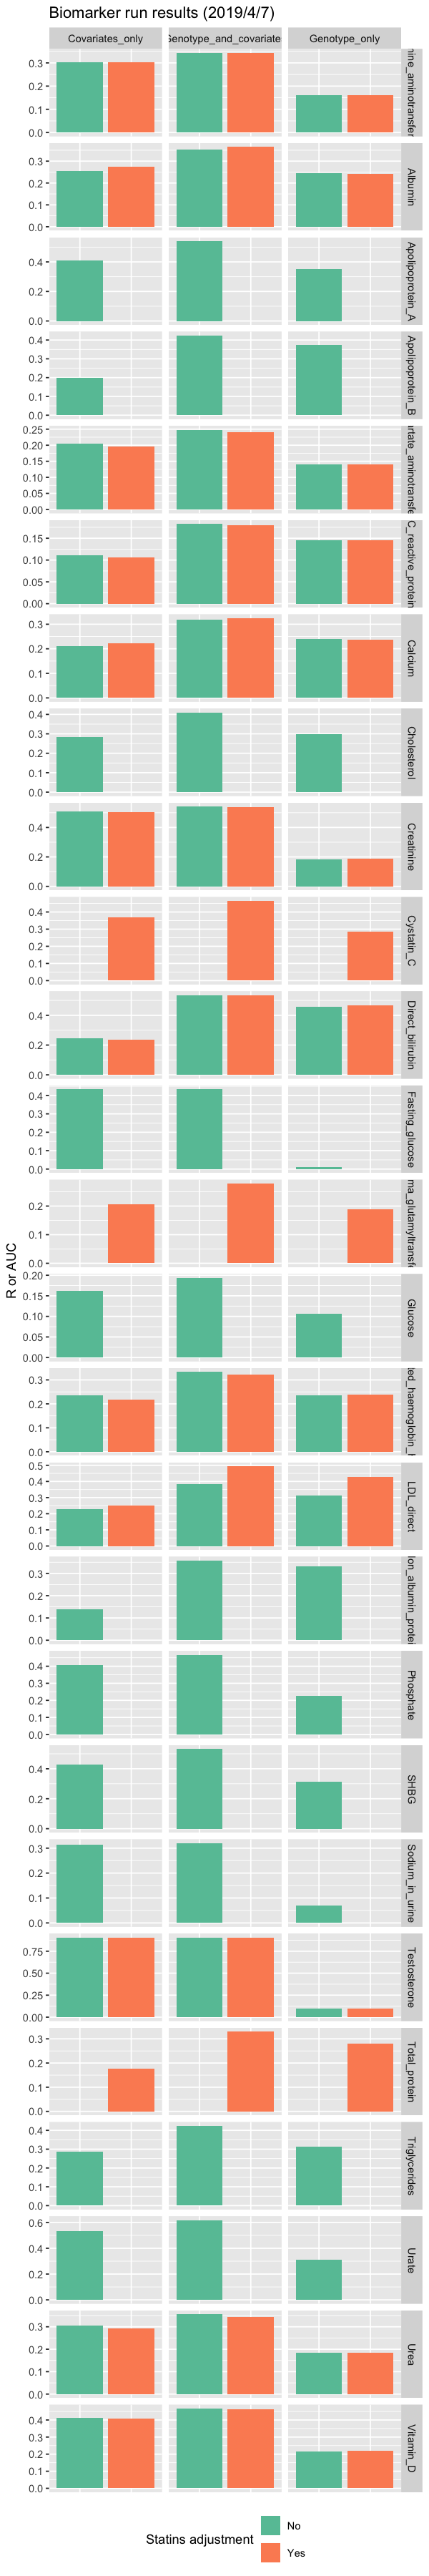

In [36]:
p

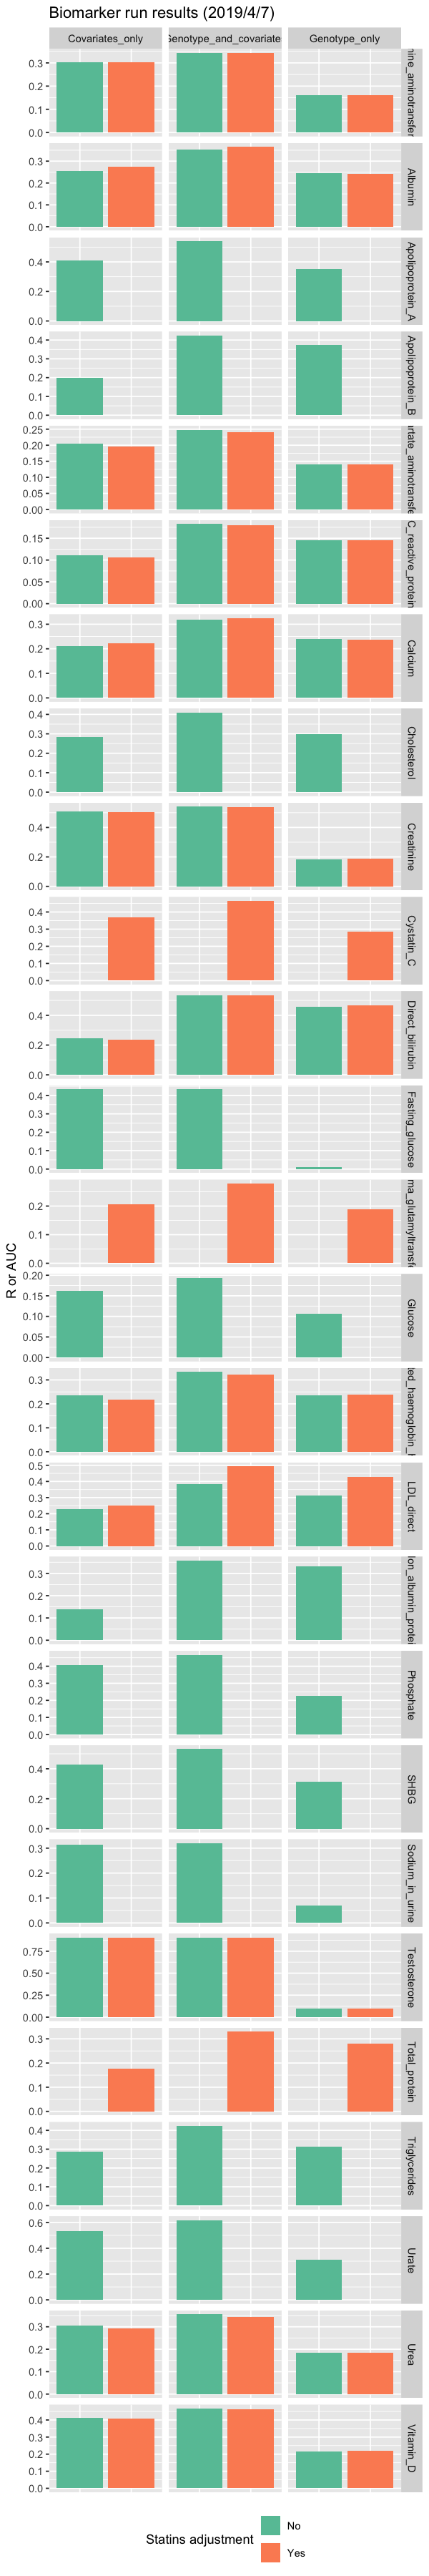

In [38]:
p + ggsave(
    'snpnset_biomarkers_20190407.png',
    width = plot_width, height = plot_height
)
